/opt/conda/lib/python3.10/site-packages/numpy/polynomial/chebyshev.py:1671: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


Baseline region 1022-1023 is too small for fitting a Chebyshev polynomial of order 3
Spectrum 1:
0      -1.000000
1      -0.998045
2      -0.996090
3      -0.994135
4      -0.992180
          ...   
1019    0.992180
1020    0.994135
1021    0.996090
1022    0.998045
1023    1.000000
Name: Wavelength, Length: 1024, dtype: float64
0       0.306363
1       0.181623
2       0.282342
3       0.227470
4       0.172598
          ...   
1019    3.156949
1020    3.225043
1021    3.293136
1022    3.603848
1023    1.129008
Name: Intensity, Length: 1024, dtype: float64
Spectrum 2:
1024   -1.000000
1025   -0.998045
1026   -0.996090
1027   -0.994135
1028   -0.992180
          ...   
2043    0.992180
2044    0.994135
2045    0.996090
2046    0.998045
2047    1.000000
Name: Wavelength, Length: 1024, dtype: float64
1024   -1.345832
1025   -1.560265
1026   -1.774699
1027   -1.443960
1028   -1.509223
          ...   
2043    0.748986
2044    0.749426
2045    1.298335
2046    0.808544
2047    0.318754
Nam

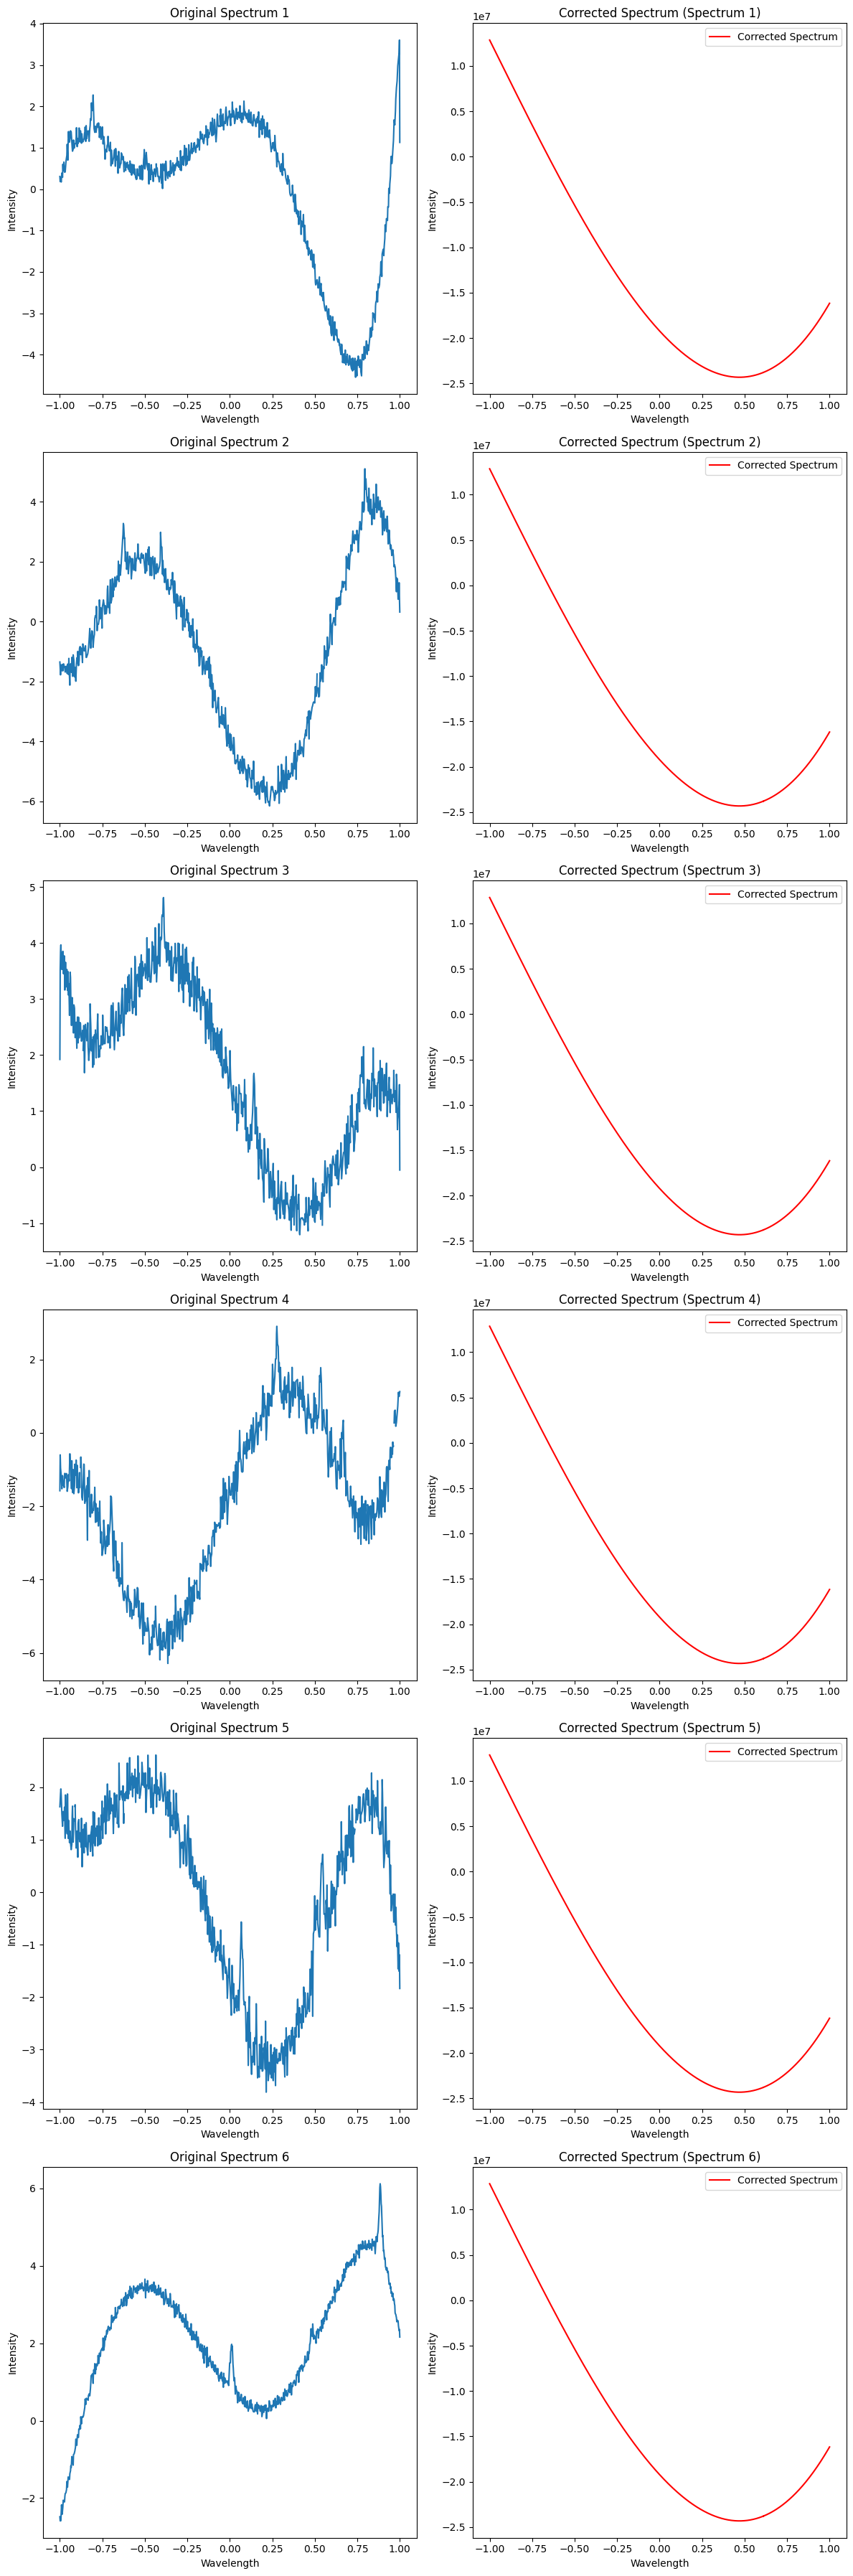

In [1]:
# 2) CORRECT BASELINE FITTING CHEBYSHEV POLYNOMIALS (SIX)
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# Define output directory
output_directory = '/kaggle/working/'

# Define file
combined_spectra_file = '/kaggle/input/output-without-rays/output_spectrum6.csv'

# Check if file exists
if os.path.isfile(combined_spectra_file):
    # Load data into a DataFrame
    combined_data = pd.read_csv(combined_spectra_file)

    # Number of spectra
    num_spectra = 6

    # List to store
    spectra = []

    # Split data into individual spectra
    spectrum_data_list = np.array_split(combined_data, num_spectra)

    for spectrum_data in spectrum_data_list:
        # Access columns from DataFrame
        wavelengths = spectrum_data['Wavelength']
        intensities = spectrum_data['Intensity']

        # Store as a tuple (wavelengths, intensities)
        spectra.append((wavelengths, intensities))

    # 1. Identify Baseline Regions (IMPROVED)
    # Calculate is_peak by comparing intensity values with the neighbors (may not work well for all types of spectra) 
    # More robust method for peak detection (SciPy's find_peaks)
    from scipy.signal import find_peaks

    def identify_baseline_regions(spectrum, min_peak_height=0.01):
        # Find peaks in spectrum
        peaks, _ = find_peaks(-spectrum, height=min_peak_height)

        baseline_regions = []
        region_start = 0

        for peak in peaks:
            if peak - region_start > 2:
                baseline_regions.append((region_start, peak))
            region_start = peak + 1

        if region_start < len(spectrum) - 1:
            baseline_regions.append((region_start, len(spectrum) - 1))

        # Filter regions based on peak height
        baseline_regions = [region for region in baseline_regions if np.min(spectrum[region[0]:region[1] + 1]) < min_peak_height]

        return baseline_regions

    # Iterate over each spectrum
    for spectrum_id, (wavelengths, intensities) in enumerate(spectra, start=1):        
        
        # 2. Fit Chebyshev Polynomials to Baseline Regions (IMPROVED)
        # Add error handling to handle cases where fit might not work as expected
        baseline_regions = identify_baseline_regions(intensities)
        
        poly_order = 3

        for start, end in baseline_regions:
            # Get wavelengths & intensities in the baseline region
            baseline_wavelengths = wavelengths[start:end]
            baseline_intensities = intensities[start:end]

            # Check if baseline region is large enough for fitting
            if len(baseline_wavelengths) < poly_order:
                print(f"Baseline region {start}-{end} is too small for fitting a Chebyshev polynomial of order {poly_order}")
                continue

            # Fit Chebyshev polynomial to baseline region
            coeffs = np.polynomial.chebyshev.chebfit(baseline_wavelengths, baseline_intensities, poly_order)
            
        # 3. Update Fitted Curve (IMPROVED)
        # Convergence check & uses a threshold to determine when to break out of loop --> best algorithm robustness 

        # Iterative loop to update fitted polynomial to ensure it remains beneath spectrum
        def identify_baseline_region(index):
            # Given an index where fitted curve exceeds spectrum, identify corresponding baseline region
            # Use baseline regions previously identified to find the one that contains index
            for start, end in baseline_regions:
                if start <= index <= end:
                    return start, end
            return None  # Return None if no matching baseline region is found

        # Set a maximum number of iterations to avoid infinite loops
        max_iterations = 10
        convergence_threshold = 0.001

        for iteration in range(max_iterations):
            # Evaluate fitted polynomial over entire spectrum range
            fitted_baseline = np.polynomial.chebyshev.chebval(wavelengths, coeffs)

            # Calculate difference between fitted curve & spectrum
            difference = intensities - fitted_baseline

            # Check if all differences are below threshold
            if all(abs(difference) < convergence_threshold):
                # If differences are below threshold, break loop
                break

            # Update fitted polynomial in regions where it exceeds spectrum
            for index, diff in enumerate(difference):
                if diff > 0:
                    # Identify corresponding baseline region
                    baseline_region = identify_baseline_region(index)

                    if baseline_region is not None:
                        start, end = baseline_region
                        # Get wavelengths & intensities in baseline region
                        baseline_wavelengths = wavelengths[start:end]
                        baseline_intensities = intensities[start:end]

                        # Fit a new Chebyshev polynomial to baseline region
                        new_coeffs = np.polynomial.chebyshev.chebfit(baseline_wavelengths, baseline_intensities, poly_order)

                        # Update coefficients where fitted curve exceeded spectrum
                        coeffs[start:end] = new_coeffs[start:end]
                        
        
    # 4. Subtract Fitted Polynomial
    # Evaluate fitted polynomial over entire spectrum range
    fitted_baseline = np.polynomial.chebyshev.chebval(wavelengths, coeffs)

    # Subtract fitted baseline from original spectrum to correct baseline
    corrected_spectrum = intensities - fitted_baseline

    # Create a DataFrame
    corrected_df = pd.DataFrame({'Wavelength': wavelengths, 'Corrected_Intensity': corrected_spectrum})

    # Specify output file path
    corrected_file_path = os.path.join(output_directory, f'corrected_baseline_spectrum{spectrum_id}.csv')

    # Save DataFrame
    corrected_df.to_csv(corrected_file_path, index=False)

    # Create a figure with subplots to visualize all spectra
    fig, axs = plt.subplots(num_spectra, 2, figsize=(12, 6 * num_spectra))

    for spectrum_id, spectrum_data in enumerate(spectrum_data_list, start=1):
        wavelengths = spectrum_data['Wavelength']
        intensities = spectrum_data['Intensity']

        print(f"Spectrum {spectrum_id}:")
        print(wavelengths)
        print(intensities)

        # Plot original spectrum in left subplot
        axs[spectrum_id - 1, 0].plot(wavelengths, intensities, label="Original Spectrum")
        axs[spectrum_id - 1, 0].set_title(f"Original Spectrum {spectrum_id}")
        axs[spectrum_id - 1, 0].set_xlabel("Wavelength")
        axs[spectrum_id - 1, 0].set_ylabel("Intensity")  
        
        # Plot Corrected Spectrum
        ax = axs[spectrum_id - 1, 1]
        ax.plot(wavelengths, corrected_spectrum, label='Corrected Spectrum', color='red')
        ax.set_title(f'Corrected Spectrum (Spectrum {spectrum_id})')
        ax.set_xlabel('Wavelength')
        ax.set_ylabel('Intensity')
        ax.legend()

# Display subplots
plt.tight_layout()
plt.show()
